## Set up

In [1]:
from helpers.clean import *
from helpers.eda import *
from helpers.model import *
from helpers.evaluate import * 

import time
start_notebook = time.time() 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import ADASYN, \
                                   SMOTE

from sklearn.ensemble import AdaBoostClassifier, \
                             RandomForestClassifier, \
                             VotingClassifier

from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, \
                         plot_tree

from sklearn.metrics import accuracy_score, \
                            classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay, \
                            f1_score, \
                            make_scorer, \
                            recall_score, \
                            roc_curve, \
                            precision_score

from sklearn.model_selection import cross_val_score, \
                                    train_test_split, \
                                    GridSearchCV    

seed = 42

teal = '#01ACA5'
purple = '#BF40BF'
sns.set_palette(sns.color_palette([teal, purple]))
white_median = dict(color='yellow')

pd.set_option('display.max_columns', 9)

import warnings
warnings.filterwarnings('ignore')

In [2]:
header = ['age', 'class_of_worker', 'industry_code', 'occupation_code', 'education', 'wage_per_hour',
          'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code',
          'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union',
          'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses',
          'divdends_from_stocks', 'tax_filer_status', 'region_of_previous_residence',
          'state_of_previous_residence', 'detailed_household_and_family_stat',
          'detailed_household_summary_in_household', 'unknown_column', 'migration_code_change_in_msa',
          'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
          'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18',
          'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self',
          'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin',
          'veterans_benefits', 'weeks_worked_in_year', 'year', 'taxable_income_amount']

columns_to_drop_eda = ['weeks_worked_in_year',
                       'industry_code',
                       'hispanic_origin',
                       'detailed_household_and_family_stat',
                       'country_of_birth_father',
                       'country_of_birth_mother',
                       'country_of_birth_self',
                       'own_business_or_self_employed',
                       'veterans_benefits',
                       'year']

start_time = time.time()

raw_train = pd.read_csv('./data/census_income_learn.csv', names=header, sep=', ')
raw_test = pd.read_csv('./data/census_income_test.csv', names=header, sep=', ')

train = pd.read_csv('./data/census_income_learn.csv', names=header, sep=', ')
test = pd.read_csv('./data/census_income_test.csv', names=header, sep=', ')

end_time = time.time()
execution_time = end_time - start_time
print(f'Loading time: {round(execution_time)} seconds')

Loading time: 15 seconds


## Cleaning

In [3]:
start_time = time.time()

train = clean_df(train, *columns_to_drop_eda)
test = clean_df(test, *columns_to_drop_eda)

end_time = time.time()
execution_time = end_time - start_time
print(f'Cleaning time: {round(execution_time)} seconds')

Cleaning time: 19 seconds


In [4]:
get_cleaning_metrics(raw_train, train, raw_test, test, type_of_test_set='Test')

79785 observations removed from the train set.
39607 observations removed from the Test set.
30 columns removed from the train set.
30 columns removed from the Test set.

Train dataset observations reduced by 40.0%.
Test dataset observations reduced by 39.7%.
Train dataset columns reduced by 71.4%.
Test dataset columns reduced by 71.4%.

The training set has 119738 observations and  12 columns.
The training set has 60155 observations and  12 columns.


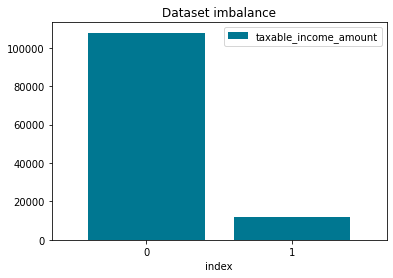

In [5]:
fig = plot_imbalance(train)
plt.show()

## Preprocessing

In [6]:
start_time = time.time()

In [7]:
train_x, train_y =  train.drop('taxable_income_amount', axis=1), train.taxable_income_amount
test_x, test_y = test.drop('taxable_income_amount', axis=1), test.taxable_income_amount

#### Dummy regressor

In [8]:
dr = DummyClassifier(strategy='most_frequent')
dr_start_time = time.time()
prediction, model_metrics = get_model_results(train_x, train_y, test_x, test_y, dr)
dr_end_time = time.time()
dr_execution_time = dr_end_time - dr_start_time
print(f'\nExecution time: {round(dr_execution_time)} seconds')


Time to train: 0 seconds
Time to predict: 0 seconds
Total time: 0 seconds
Accuracy:) 0.9013
F-score: 0.0
Recall: 0.0

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     54217
           1       0.00      0.00      0.00      5938

    accuracy                           0.90     60155
   macro avg       0.45      0.50      0.47     60155
weighted avg       0.81      0.90      0.85     60155

[[54217     0]
 [ 5938     0]]


Execution time: 0 seconds


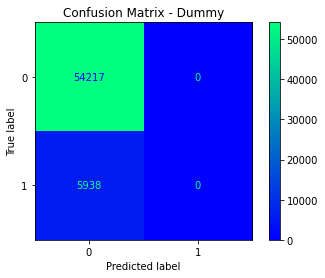

In [9]:
title = 'Confusion Matrix - Dummy'
predicted_y = prediction
display_confusion_matrix(title=title, test_y=test_y, predicted_y=predicted_y)

### Get dummies

In [10]:
train_x_dummies = pd.get_dummies(train_x)
test_x_dummies = pd.get_dummies(test_x)

### Scale

In [11]:
train_scaler = StandardScaler().fit(train_x_dummies)
train_x_scaled = train_scaler.transform(train_x_dummies)

test_scaler = StandardScaler().fit(test_x_dummies)
test_x_scaled = test_scaler.transform(test_x_dummies)

### Split

In [12]:
train_x_split, valid_x, train_y_split, valid_y = train_test_split(train_x_scaled,
                                                                  train_y,
                                                                  test_size=0.33,
                                                                  random_state=42)

train_x = train_x_split
train_y = train_y_split
test_x = test_x_scaled

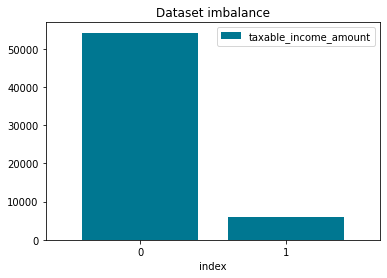

In [13]:
fig = plot_imbalance(test)
plt.show()

In [14]:
test.taxable_income_amount.value_counts(normalize=True)

0    0.901288
1    0.098712
Name: taxable_income_amount, dtype: float64

### SMOTE

In [15]:
model = SMOTE()
smote_x, smote_y = model.fit_resample(train_x, train_y)
smote_y = smote_y.astype('int')

### ADASYN

In [16]:
adasyn = ADASYN(random_state=42)
adasyn_x, adasyn_y = adasyn.fit_resample(train_x, train_y)

### Dummy regressor

In [17]:
dr = DummyClassifier(strategy='most_frequent')
dr_start_time = time.time()
prediction, model_metrics = get_model_results(train_x, train_y, train_x, train_y, dr)
dr_end_time = time.time()
dr_execution_time = dr_end_time - dr_start_time
print(f'\nExecution time: {round(dr_execution_time)} seconds')


Time to train: 0 seconds
Time to predict: 0 seconds
Total time: 0 seconds
Accuracy:) 0.9004
F-score: 0.0
Recall: 0.0

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     72230
           1       0.00      0.00      0.00      7994

    accuracy                           0.90     80224
   macro avg       0.45      0.50      0.47     80224
weighted avg       0.81      0.90      0.85     80224

[[72230     0]
 [ 7994     0]]


Execution time: 0 seconds


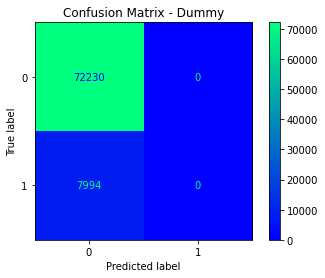

In [18]:
title = 'Confusion Matrix - Dummy'
predicted_y = prediction
display_confusion_matrix(title=title, test_y=train_y, predicted_y=predicted_y)

In [19]:
end_time = time.time()
execution_time = end_time - start_time
print(f'Preprocessing time: {round(execution_time)} seconds')

Preprocessing time: 21 seconds


## Modeling

### Models

In [20]:
train_start = time.time()

In [21]:
models = {}

#### Dummy classifier

In [22]:
dr = DummyClassifier(strategy='most_frequent')
models['Dummy classifier'] = dr

#### Logistic regression

In [23]:
lr = LogisticRegression(random_state=seed) #class_weight={0:1, 1:15}, 
models['Logistic regression'] = lr

#### Neural net

In [24]:
nn = MLPClassifier(max_iter=300)
models['Neural net'] = nn

#### Decision Tree

In [25]:
dt = DecisionTreeClassifier(random_state=seed) #max_depth=5, class_weight={0: 1, 1: 12}
models['Decision tree'] = dt

#### Random forest

In [26]:
rf = RandomForestClassifier(random_state=seed) #class_weight={0: 1, 1: 12},
                                               #criterion='gini',
                                               #max_depth=13,
                                               #max_features='log2',
                                               #min_samples_leaf=10,
                                               #n_estimators=26,
                                               #n_jobs=-1,
models['Random forest'] = rf

#### Naive Bayes

In [27]:
gnb = GaussianNB()
models['Naive Bayes'] = gnb

#### K-nearest neighbors

In [28]:
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
models['K-nearest neighbors'] = knn

#### Support vector machine

In [29]:
svm = SVC(C=0.1, kernel='poly', random_state=seed)
models['Support vector machine'] = svm

#### Quadratic discriminant analysis

In [30]:
qda = QuadraticDiscriminantAnalysis()
models['Quadratic Discriminant Analysis'] = qda

#### Adaboost

In [31]:
abc = AdaBoostClassifier(random_state=seed) #n_estimators=100, 
models['Adaboost'] = qda

In [32]:
print('Models originally considered:')
for key in models.keys():
    print('-', key)

Models originally considered:
- Dummy classifier
- Logistic regression
- Neural net
- Decision tree
- Random forest
- Naive Bayes
- K-nearest neighbors
- Support vector machine
- Quadratic Discriminant Analysis
- Adaboost


#### Pipeline

In [33]:
# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', lr),
                                              ('nn', nn),
                                              ('dt', dt),
                                              ('rf', rf),
                                              ('knn', knn),
                                              ('svm', svm),
                                              ('qda', qda),
                                              ('abc', abc)],
                                              voting='hard')

### Evaluating model performance

In [34]:
modeling_start = time.time()

In [35]:
metric_columns = columns=['model', 'time_to_train', 'time_to_predict', 'total_time', 'accuracy', 'f1', 'recall']
metrics_train = metrics_valid = metrics_test = pd.DataFrame(columns=metric_columns)

#### Train

In [36]:
train_start_time = time.time()



DUMMY CLASSIFIER

Time to train: 0 seconds
Time to predict: 0 seconds
Total time: 0 seconds
Accuracy:) 0.9004
F-score: 0.0
Recall: 0.0

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     72230
           1       0.00      0.00      0.00      7994

    accuracy                           0.90     80224
   macro avg       0.45      0.50      0.47     80224
weighted avg       0.81      0.90      0.85     80224

[[72230     0]
 [ 7994     0]]



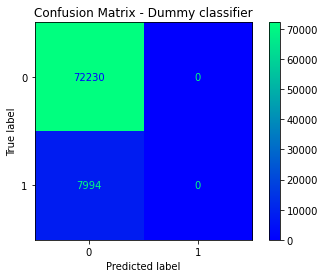

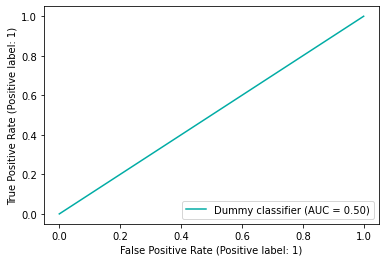



LOGISTIC REGRESSION

Time to train: 1 seconds
Time to predict: 0 seconds
Total time: 1 seconds
Accuracy:) 0.9114
F-score: 0.3774
Recall: 0.2695

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     72230
           1       0.63      0.27      0.38      7994

    accuracy                           0.91     80224
   macro avg       0.78      0.63      0.66     80224
weighted avg       0.89      0.91      0.90     80224

[[70962  1268]
 [ 5840  2154]]



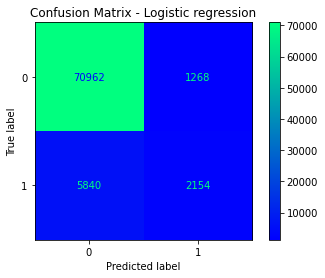

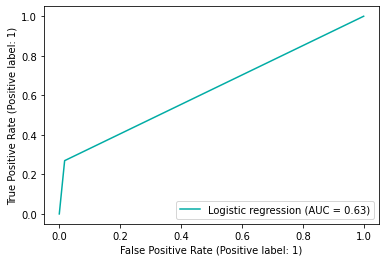



NEURAL NET

Time to train: 104 seconds
Time to predict: 0 seconds
Total time: 104 seconds
Accuracy:) 0.9219
F-score: 0.4784
Recall: 0.3595

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     72230
           1       0.71      0.36      0.48      7994

    accuracy                           0.92     80224
   macro avg       0.82      0.67      0.72     80224
weighted avg       0.91      0.92      0.91     80224

[[71084  1146]
 [ 5120  2874]]



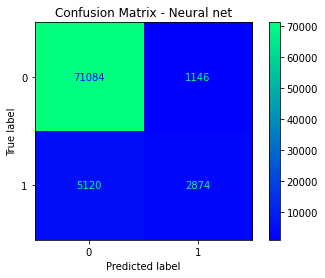

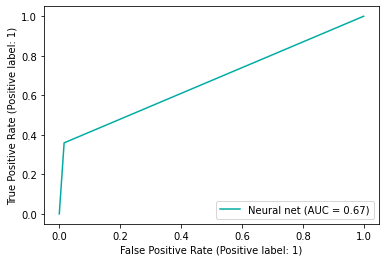



DECISION TREE

Time to train: 1 seconds
Time to predict: 0 seconds
Total time: 1 seconds
Accuracy:) 0.9866
F-score: 0.9289
Recall: 0.88

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     72230
           1       0.98      0.88      0.93      7994

    accuracy                           0.99     80224
   macro avg       0.99      0.94      0.96     80224
weighted avg       0.99      0.99      0.99     80224

[[72112   118]
 [  959  7035]]



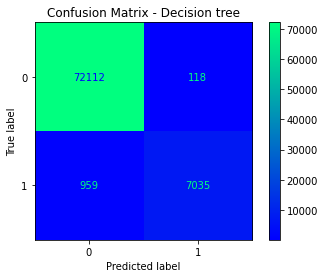

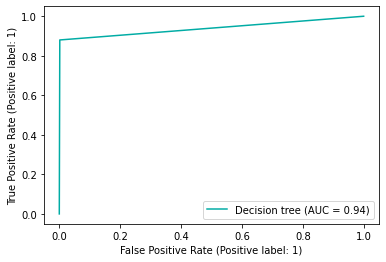



RANDOM FOREST

Time to train: 10 seconds
Time to predict: 2 seconds
Total time: 12 seconds
Accuracy:) 0.9865
F-score: 0.9302
Recall: 0.9041

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     72230
           1       0.96      0.90      0.93      7994

    accuracy                           0.99     80224
   macro avg       0.97      0.95      0.96     80224
weighted avg       0.99      0.99      0.99     80224

[[71912   318]
 [  767  7227]]



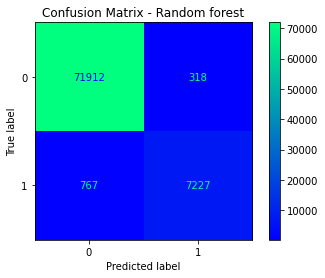

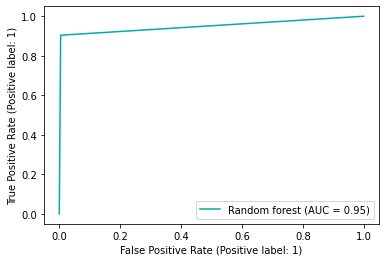



NAIVE BAYES

Time to train: 0 seconds
Time to predict: 0 seconds
Total time: 0 seconds
Accuracy:) 0.4603
F-score: 0.2554
Recall: 0.9288

              precision    recall  f1-score   support

           0       0.98      0.41      0.58     72230
           1       0.15      0.93      0.26      7994

    accuracy                           0.46     80224
   macro avg       0.56      0.67      0.42     80224
weighted avg       0.90      0.46      0.54     80224

[[29501 42729]
 [  569  7425]]



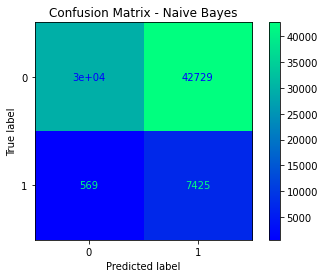

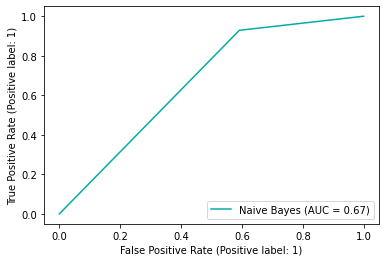



K-NEAREST NEIGHBORS

Time to train: 0 seconds
Time to predict: 93 seconds
Total time: 93 seconds
Accuracy:) 0.9893
F-score: 0.9468
Recall: 0.951

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     72230
           1       0.94      0.95      0.95      7994

    accuracy                           0.99     80224
   macro avg       0.97      0.97      0.97     80224
weighted avg       0.99      0.99      0.99     80224

[[71767   463]
 [  392  7602]]



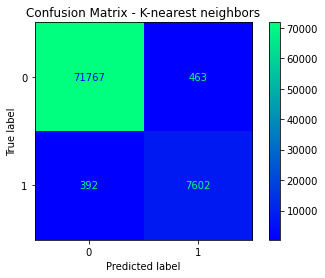

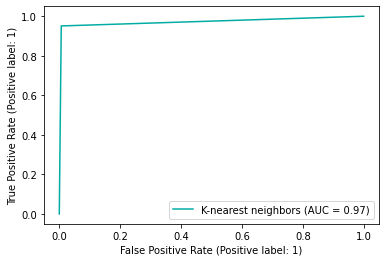



SUPPORT VECTOR MACHINE

Time to train: 554 seconds
Time to predict: 79 seconds
Total time: 633 seconds
Accuracy:) 0.9092
F-score: 0.2378
Recall: 0.1422

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     72230
           1       0.73      0.14      0.24      7994

    accuracy                           0.91     80224
   macro avg       0.82      0.57      0.59     80224
weighted avg       0.89      0.91      0.88     80224

[[71799   431]
 [ 6857  1137]]



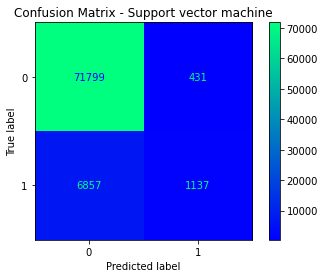

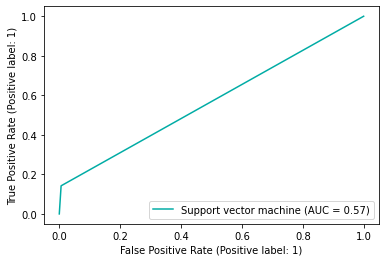



QUADRATIC DISCRIMINANT ANALYSIS

Time to train: 1 seconds
Time to predict: 0 seconds
Total time: 1 seconds
Accuracy:) 0.3233
F-score: 0.2186
Recall: 0.9501

              precision    recall  f1-score   support

           0       0.98      0.25      0.40     72230
           1       0.12      0.95      0.22      7994

    accuracy                           0.32     80224
   macro avg       0.55      0.60      0.31     80224
weighted avg       0.89      0.32      0.38     80224

[[18341 53889]
 [  399  7595]]



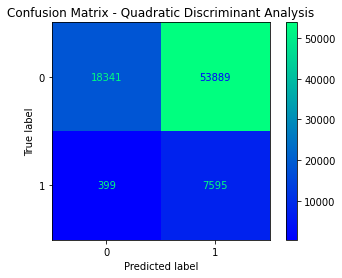

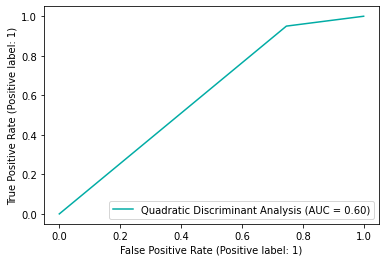



ADABOOST

Time to train: 1 seconds
Time to predict: 0 seconds
Total time: 1 seconds
Accuracy:) 0.3233
F-score: 0.2186
Recall: 0.9501

              precision    recall  f1-score   support

           0       0.98      0.25      0.40     72230
           1       0.12      0.95      0.22      7994

    accuracy                           0.32     80224
   macro avg       0.55      0.60      0.31     80224
weighted avg       0.89      0.32      0.38     80224

[[18341 53889]
 [  399  7595]]



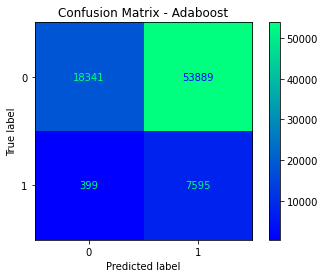

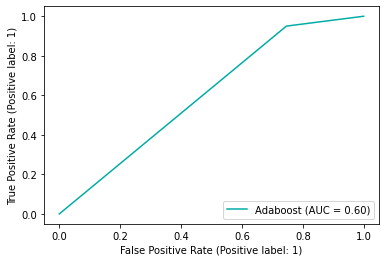

In [37]:
for model_name, model in models.items():
    metrics_train = train_and_test_model(metrics_df=metrics_train,
                                         train_x=train_x,
                                         train_y=train_y,
                                         test_x=train_x,
                                         test_y=train_y,
                                         model=model,
                                         model_name=model_name)

In [38]:
train_end_time = time.time()
train_execution_time = train_end_time - train_start_time
print(f'Train set execution time: {round(train_execution_time / 60)} minutes')

Train set execution time: 14 minutes


In [39]:
metrics_train.sort_values(by=['f1', 'time_to_predict'], ascending=False)

,model,time_to_train,time_to_predict,total_time,accuracy,f1,recall
0,K-nearest neighbors,0,93,93,0.989342,0.946759,0.950963
0,Random forest,10,2,12,0.986475,0.930176,0.904053
0,Decision tree,1,0,1,0.986575,0.928897,0.880035
0,Neural net,104,0,104,0.921894,0.478442,0.359520
0,Logistic regression,1,0,1,0.911398,0.377365,0.269452
0,Naive Bayes,0,0,0,0.460286,0.255383,0.928822
0,Support vector machine,554,79,633,0.909154,0.237816,0.142232
0,Quadratic Discriminant Analysis,1,0,1,0.323295,0.218630,0.950088
0,Adaboost,1,0,1,0.323295,0.218630,0.950088
0,Dummy classifier,0,0,0,0.900354,0.000000,0.000000


We can already identify models that perform poorly on the very dataset they were trained upon. Let's get rid of those.

In [40]:
poor_models = metrics_train[metrics_train.f1 < 0.50].model

So our efforts will most probably focus on obtaining a good decision tree, and then building a random forest on top of it to mitigate overfitting risks.

In [41]:
for model in poor_models:
    if model in models.keys():
        del models[model]
        
print('Models finally considered for training:')
for key in models.keys():
    print('-', key)

Models finally considered for training:
- Decision tree
- Random forest
- K-nearest neighbors


We can now consider:
- a K-Nearest Neighbors:
  - time to train: almost instantaneous
  - time to predict: about 2 minutes
  - F1 score: best
  - explainability: easy
  - risk: overfitting
- a Random Forest:
  - time to train: about 10 seconds
  - time to predict: about 2 seconds
  - F1 score: very good
  - explainability: easy
  - risk: overfitting
- a Decision Tree:
  - time to train: 1 second
  - time to predict: almost instantaneous
  - F1 score: very good
  - explainability: easy
  - risk: overfitting practically guaranteed
- a Neural Net:
  - time to train: about 2 minutes
  - time to predict: almost instantaneous
  - F1 score: not great
  - explainability: black box
  - risk: not understanding the model

Based on this assessment above, let's give a chance to these algorithms on the validation set

#### Validate

In [42]:
valid_start_time = time.time()



DECISION TREE

Time to train: 1 seconds
Time to predict: 0 seconds
Total time: 1 seconds
Accuracy:) 0.8768
F-score: 0.3831
Recall: 0.3853

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     35590
           1       0.38      0.39      0.38      3924

    accuracy                           0.88     39514
   macro avg       0.66      0.66      0.66     39514
weighted avg       0.88      0.88      0.88     39514

[[33133  2457]
 [ 2412  1512]]



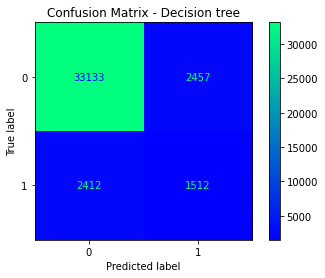

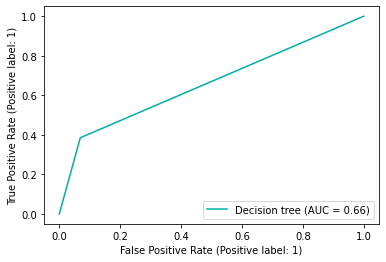



RANDOM FOREST

Time to train: 11 seconds
Time to predict: 1 seconds
Total time: 12 seconds
Accuracy:) 0.9058
F-score: 0.4257
Recall: 0.3517

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     35590
           1       0.54      0.35      0.43      3924

    accuracy                           0.91     39514
   macro avg       0.74      0.66      0.69     39514
weighted avg       0.89      0.91      0.90     39514

[[34410  1180]
 [ 2544  1380]]



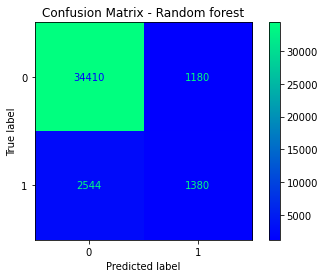

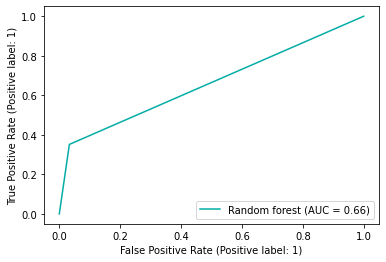



K-NEAREST NEIGHBORS

Time to train: 0 seconds
Time to predict: 45 seconds
Total time: 45 seconds
Accuracy:) 0.8736
F-score: 0.38
Recall: 0.3902

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     35590
           1       0.37      0.39      0.38      3924

    accuracy                           0.87     39514
   macro avg       0.65      0.66      0.65     39514
weighted avg       0.88      0.87      0.88     39514

[[32987  2603]
 [ 2393  1531]]



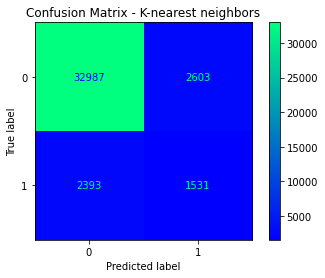

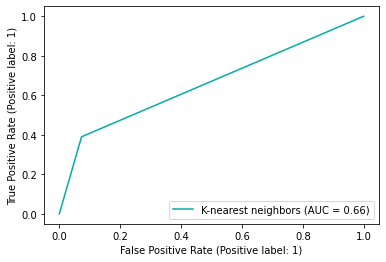

In [43]:
for model_name, model in models.items():
    metrics_valid = train_and_test_model(metrics_df=metrics_valid,
                                         train_x=train_x,
                                         train_y=train_y,
                                         test_x=valid_x,
                                         test_y=valid_y,
                                         model=model,
                                         model_name=model_name)

In [44]:
valid_end_time = time.time()
valid_execution_time = valid_end_time - valid_start_time
print(f'Validation set execution time: {round(valid_execution_time / 60)} minutes')

Validation set execution time: 1 minutes


In [45]:
metrics_valid.sort_values(by=['f1', 'time_to_predict'], ascending=False)

,model,time_to_train,time_to_predict,total_time,accuracy,f1,recall
0,Random forest,11,1,12,0.905755,0.425663,0.351682
0,Decision tree,1,0,1,0.876778,0.383124,0.385321
0,K-nearest neighbors,0,45,45,0.873564,0.379995,0.390163


The models we considered all lost about 0.5 points on their F1 score. That's a severe hit. Before we try to improve them individually, let's see if an additional manipulation on the dataset, to deal with its imbalance, would improve our results.  

Also, KNN is now our worst performing model, and neural net our best performing one. Random Forest is close on its tail though, so it definitely looks like a combination of work on a decision tree and a random forest would be the way to go.

Out of curiosity, what are the most important features recommended by a Random Forest model?

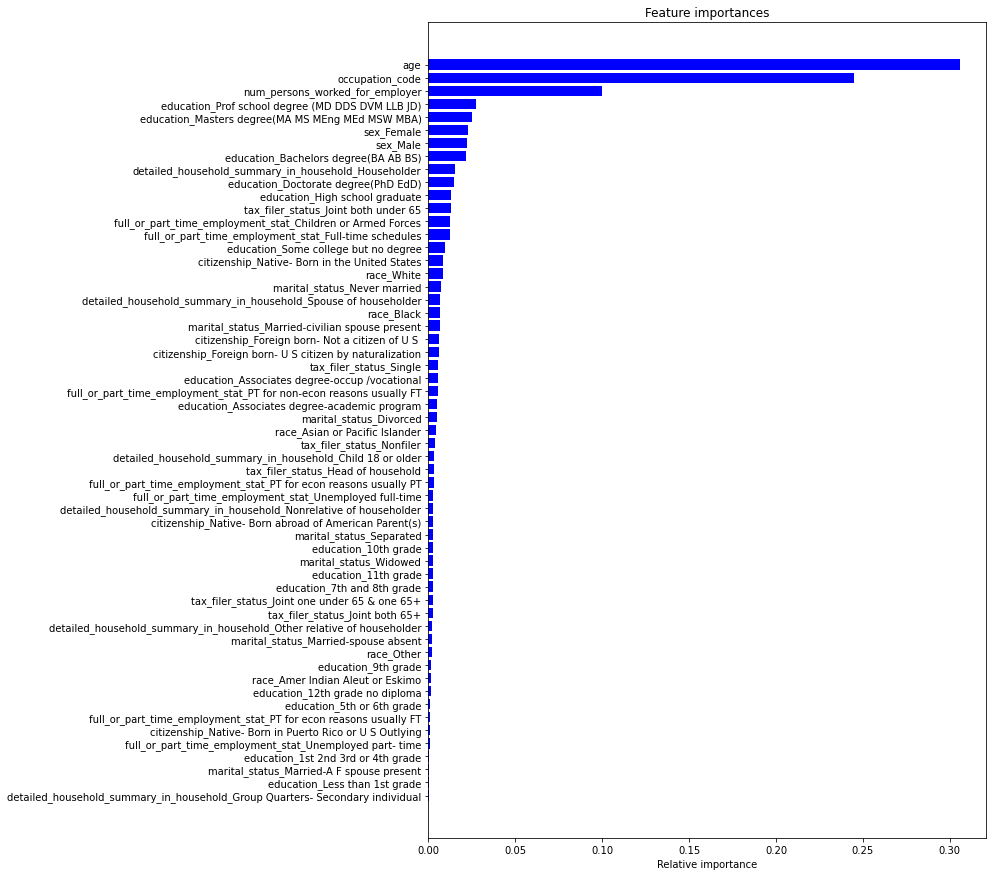

In [46]:
# fitting the model
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(train_x, train_y)

# plotting feature importances
features = train_x_dummies.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,15))
plt.title('Feature importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.show()

#### Try to deal with imbalance: SMOTE

In [47]:
smote_metrics_valid = pd.DataFrame(columns=metric_columns)



DECISION TREE

Time to train: 2 seconds
Time to predict: 0 seconds
Total time: 2 seconds
Accuracy:) 0.8683
F-score: 0.3757
Recall: 0.3991

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     35590
           1       0.35      0.40      0.38      3924

    accuracy                           0.87     39514
   macro avg       0.64      0.66      0.65     39514
weighted avg       0.88      0.87      0.87     39514

[[32744  2846]
 [ 2358  1566]]



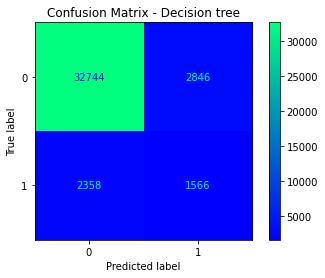

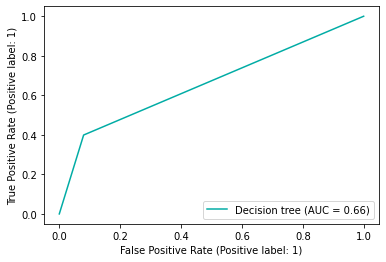



RANDOM FOREST

Time to train: 26 seconds
Time to predict: 1 seconds
Total time: 27 seconds
Accuracy:) 0.8853
F-score: 0.4515
Recall: 0.4753

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     35590
           1       0.43      0.48      0.45      3924

    accuracy                           0.89     39514
   macro avg       0.69      0.70      0.69     39514
weighted avg       0.89      0.89      0.89     39514

[[33118  2472]
 [ 2059  1865]]



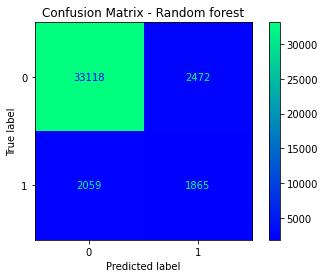

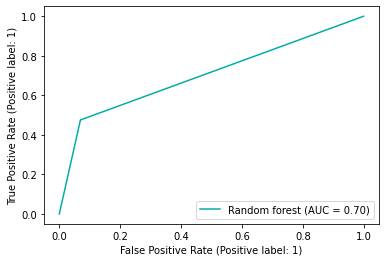



K-NEAREST NEIGHBORS

Time to train: 0 seconds
Time to predict: 83 seconds
Total time: 83 seconds
Accuracy:) 0.848
F-score: 0.3857
Recall: 0.4804

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     35590
           1       0.32      0.48      0.39      3924

    accuracy                           0.85     39514
   macro avg       0.63      0.68      0.65     39514
weighted avg       0.88      0.85      0.86     39514

[[31624  3966]
 [ 2039  1885]]



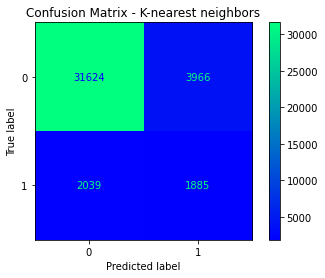

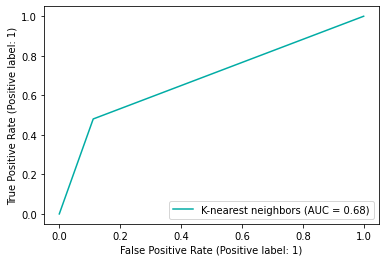

In [48]:
for model_name, model in models.items():
    smote_metrics_valid = train_and_test_model(metrics_df=smote_metrics_valid,
                                               train_x=smote_x,
                                               train_y=smote_y,
                                               test_x=valid_x,
                                               test_y=valid_y,
                                               model=model,
                                               model_name=model_name)

In [49]:
smote_metrics_valid.sort_values(by=['f1', 'time_to_predict'], ascending=False)

,model,time_to_train,time_to_predict,total_time,accuracy,f1,recall
0,Random forest,26,1,27,0.885332,0.451519,0.475280
0,K-nearest neighbors,0,83,83,0.848029,0.385678,0.480377
0,Decision tree,2,0,2,0.868300,0.375720,0.399083


We don't see any improvement here. Let's try with ADASYN.

#### Try to deal with imbalance: ADASYN

In [50]:
adasyn_metrics_valid = pd.DataFrame(columns=metric_columns)



DECISION TREE

Time to train: 2 seconds
Time to predict: 0 seconds
Total time: 2 seconds
Accuracy:) 0.8699
F-score: 0.3789
Recall: 0.3996

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     35590
           1       0.36      0.40      0.38      3924

    accuracy                           0.87     39514
   macro avg       0.65      0.66      0.65     39514
weighted avg       0.88      0.87      0.87     39514

[[32806  2784]
 [ 2356  1568]]



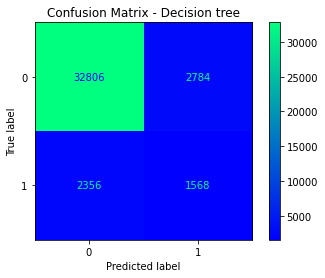

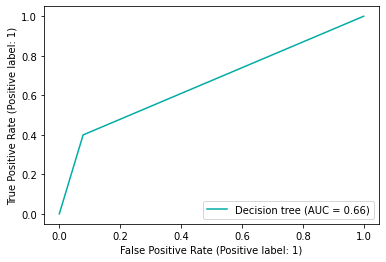



RANDOM FOREST

Time to train: 24 seconds
Time to predict: 1 seconds
Total time: 25 seconds
Accuracy:) 0.8821
F-score: 0.4448
Recall: 0.4755

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     35590
           1       0.42      0.48      0.44      3924

    accuracy                           0.88     39514
   macro avg       0.68      0.70      0.69     39514
weighted avg       0.89      0.88      0.89     39514

[[32989  2601]
 [ 2058  1866]]



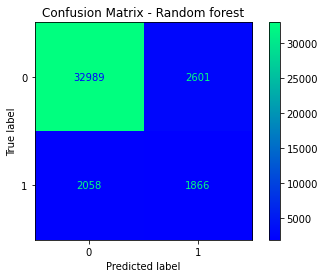

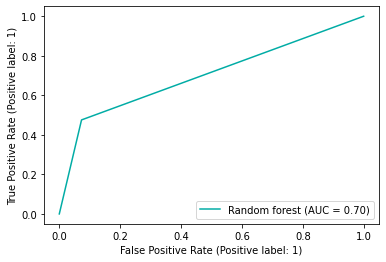



K-NEAREST NEIGHBORS

Time to train: 0 seconds
Time to predict: 84 seconds
Total time: 84 seconds
Accuracy:) 0.8447
F-score: 0.3833
Recall: 0.486

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     35590
           1       0.32      0.49      0.38      3924

    accuracy                           0.84     39514
   macro avg       0.63      0.69      0.65     39514
weighted avg       0.88      0.84      0.86     39514

[[31470  4120]
 [ 2017  1907]]



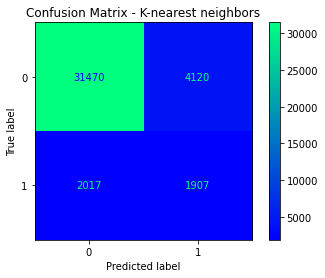

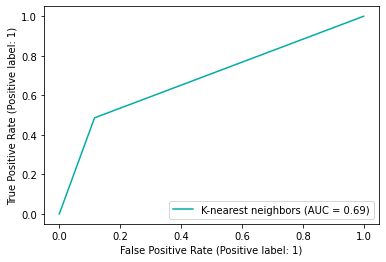

In [51]:
for model_name, model in models.items():
    adasyn_metrics_valid = train_and_test_model(metrics_df=adasyn_metrics_valid,
                                                 train_x=adasyn_x,
                                                 train_y=adasyn_y,
                                                 test_x=valid_x,
                                                 test_y=valid_y,
                                                 model=model,
                                                 model_name=model_name)

In [52]:
adasyn_metrics_valid.sort_values(by=['f1', 'time_to_predict'], ascending=False)

,model,time_to_train,time_to_predict,total_time,accuracy,f1,recall
0,Random forest,24,1,25,0.882092,0.444762,0.475535
0,K-nearest neighbors,0,84,84,0.844688,0.383278,0.485984
0,Decision tree,2,0,2,0.869920,0.378927,0.399592


No improvement either. We'd like to avoid PCA, since we'd lose in explainability, so let's try some simple hyparameter tuning first.

#### Hyperparameter tuning

In [53]:
tuning_start = time.time()

In [ ]:
rf = RandomForestClassifier()

param_grid = {'class_weight': ['balanced'],
              'n_estimators': [10,100,500,700],
              'max_features': ['auto','log2'],
              'max_depth' : [10, 100],
              'min_samples_leaf': [0.001, 0.01, 0.05],
              'criterion': ['gini', 'entropy']
             }

#scorer = {'F1': make_scorer(f1_score)}

grid_rf = GridSearchCV(rf, param_grid=param_grid, scoring='f1', cv=5, verbose=1)
grid_rf.fit(train_x, train_y)

print(grid_rf.best_params_)

prediction = grid_rf.predict(valid_x)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:
grid_rf.best_score_

In [ ]:
tuning_end = time.time()
tuning_execution_time = tuning_end - tuning_start
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(valid_y, prediction, cmap='winter')
plt.title('Confusion Matrix - Random Forest with SMOTE (testing data)')
#plt.savefig(fname='011.png', format='png', dpi=400)
plt.show()

In [ ]:
rf = RandomForestClassifier('class_weight': 'balanced',
                            'criterion': 'gini',
                            'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 0.001, 'n_estimators': 300)
fig = plt.figure(figsize=(15, 10))
plot_tree(model.estimators_[0], 
          feature_names=train_x_dummies.columns,
          class_names=['0', '1'], 
          filled=True, impurity=True, 
          rounded=True)
plt.show()

#### Test

In [ ]:
final_metrics = pd.DataFrame(columns=metric_columns)

In [ ]:
final_metrics = train_and_test_model(metrics_df=final_metrics,
                                     train_x=train_x,
                                     train_y=train_y,
                                     test_x=test_x,
                                     test_y=test_y,
                                     model=rf,
                                     model_name='Random Forest')

## End

In [ ]:
end_notebook = time.time()
print(f'Analysis took {round((end_notebook - start_notebook) / 60)} minutes to run.')